#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [ ]:
from __future__ import annotations
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from typing import Optional, Union

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [ ]:
def calc_entropy(classes_counted: np.ndarray, num_samples: int) -> float:
    entropy_sum = 0
    for class_counted in classes_counted:
        if class_counted == 0:
            continue
        class_possibility = class_counted / num_samples
        entropy_sum += class_possibility * math.log2(class_possibility)
    return -entropy_sum


class Group:
    def __init__(self, group_classes: np.ndarray):
        self.group_classes = group_classes
        self.entropy = self.get_group_entropy()

    def __len__(self):
        return self.group_classes.size

    def get_group_entropy(self) -> float:
        classes_counted = []
        for single_class in np.unique(self.group_classes):
            classes_counted.append(np.sum(self.group_classes == single_class))
        return calc_entropy(classes_counted, self.group_classes.size)


class Node:
    def __init__(self, split_feature_index: int, split_val: float, depth: Optional[int] = None,
                 child_node_a: Optional[Node] = None, child_node_b: Optional[Node] = None,
                 val: Optional[int] = None):
        self.split_feature_index = split_feature_index
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, features_row_data: np.ndarray) -> int:
        if self.child_node_a is None and self.child_node_b is None:
            return self.val

        if features_row_data[self.split_feature_index] < self.split_val:
            return self.child_node_a.predict(features_row_data)
        return self.child_node_b.predict(features_row_data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth: int):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group) -> float:
        num_of_elements = len(group_a) + len(group_b)
        group_a_possibility = len(group_a) / num_of_elements
        group_b_possibility = len(group_b) / num_of_elements
        return group_a_possibility * group_a.get_group_entropy() + \
            group_b_possibility * group_b.get_group_entropy()

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group) -> float:
        return parent_group.get_group_entropy() - self.get_split_entropy(child_group_a,
                                                                         child_group_b)

    def get_best_feature_split_and_info_gain(self, feature_values: np.ndarray,
                                             classes: np.ndarray) -> tuple[float, float]:
        features_sorted = sorted(feature_values)
        best_info_gain, best_split_value = None, None
        for i, feature_value in enumerate(features_sorted):
            if i == len(features_sorted) - 1:
                break
            is_next_feature_same = features_sorted[i + 1] == feature_value
            if not is_next_feature_same:
                splitting_value = (features_sorted[i + 1] + feature_value) / 2
                group_1 = classes[feature_values < splitting_value]
                group_2 = classes[feature_values >= splitting_value]
                info_gain = self.get_information_gain(Group(classes), Group(group_1), Group(group_2))
                if best_info_gain is None or info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split_value = splitting_value
        return best_split_value, best_info_gain

    def get_best_split(self, data: np.ndarray, classes: np.ndarray) -> dict[str, Union[int, float]]:
        best_feature_info = {
            'feature_index': None,
            'split_value': None,
            'info_gain': None
        }

        for i in range(len(data[0])):
            feature_values = data[:, i]
            split_value, info_gain = self.get_best_feature_split_and_info_gain(feature_values, classes)
            if split_value is None and info_gain is None:
                continue
            if best_feature_info['feature_index'] is None or info_gain > best_feature_info['info_gain']:
                best_feature_info['feature_index'] = i
                best_feature_info['split_value'] = split_value
                best_feature_info['info_gain'] = info_gain
        return best_feature_info

    def build_tree(self, data: np.ndarray, classes: np.ndarray, depth: int = 0) -> Node:
        if np.unique(classes).size == 1 or depth == self.max_depth:
            return self._creat_leaf_node(classes, depth)

        best_split_info = self.get_best_split(data, classes)
        best_feature_index = best_split_info['feature_index']
        best_split_value = best_split_info['split_value']

        is_split_not_possible = best_feature_index is None and best_split_value is None
        if is_split_not_possible:
            return self._creat_leaf_node(classes, depth)

        left_group_cond = data[:, best_feature_index] < best_split_value
        right_group_cond = data[:, best_feature_index] >= best_split_value
        left_data, left_classes = data[left_group_cond], classes[left_group_cond]
        right_data, right_classes = data[right_group_cond], classes[right_group_cond]

        current_node = Node(split_feature_index=best_feature_index, split_val=best_split_value,
                            depth=depth, child_node_a=None, child_node_b=None,
                            val=None)

        left_child = self.build_tree(left_data, left_classes, depth + 1)
        right_child = self.build_tree(right_data, right_classes, depth + 1)

        current_node.child_node_a = left_child
        current_node.child_node_b = right_child

        if depth == 0:
            self.tree = current_node
        return current_node

    def _creat_leaf_node(self, classes: np.ndarray, depth: int) -> Node:
        return Node(split_feature_index=None, split_val=None, depth=depth,
                    child_node_a=None, child_node_b=None,
                    val=self._get_most_common_class(classes))

    def _get_most_common_class(self, classes: np.ndarray) -> int:
        return np.bincount(classes).argmax()

    def predict(self, features_row_data: np.ndarray) -> int:
        return self.tree.predict(features_row_data)


def calc_accuracy(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray,
                  depth: int = 3) -> float:
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    predicted = []
    for sample, _ in zip(x_test, y_test):
        prediction = dc.predict(sample)
        predicted.append(prediction)
    return sum(predicted == y_test) / y_test.size


## Wykonanie podstawowego testu

In [8]:
dc = DecisionTreeClassifier(3)
dc.build_tree(x_train, y_train)
print("(Predicted class, actual class):")
for sample, actual_class in zip(x_test, y_test):
    prediction = dc.predict(sample)
    print(f"({prediction}, {actual_class})", end=' ')
print(f"\nAccuracy: {calc_accuracy(*train_test_split(x, y, test_size=0.1, random_state=123), depth=3)}")

(Predicted class, actual class):
(2, 1) (2, 2) (2, 2) (1, 1) (0, 0) (2, 2) (1, 1) (0, 0) (0, 0) (1, 1) (2, 2) (0, 0) (1, 1) (2, 2) (2, 2) 
Accuracy: 0.9333333333333333


## Testowanie - zwiększanie głębkości

In [ ]:
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=1))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=2))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=3))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=4))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=5))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=6))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=7))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=8))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=9))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=10))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=11))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1), depth=12))

## Zwiększanie głębokości - wyniki

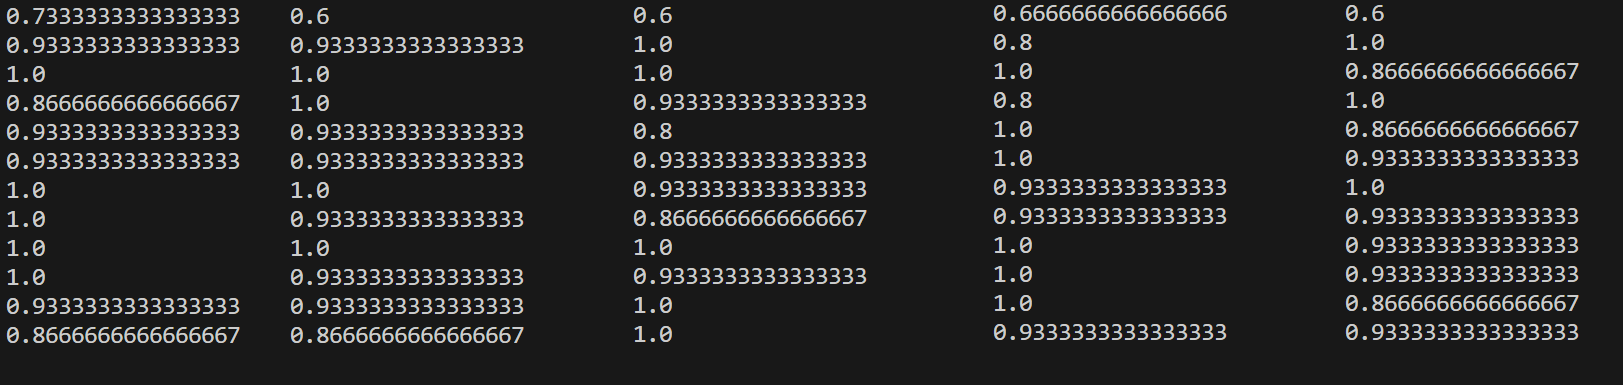


## Zwiększanie głębokości - wnioski

- Zwiększanie głębokości drzewa, nie zawsze prowadzi nas do lepszych wyników (drzewo może stać się za bardzo dopasowane do zbioru uczącego - overfitting)

----
## Testowanie - zwiększanie test_size (zmniejszanie zbioru uczącego)

In [ ]:
print(calc_accuracy(*train_test_split(x, y, test_size=0.05)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.1)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.2)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.3)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.4)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.5)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.6)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.7)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.8)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.9)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.95)))
print(calc_accuracy(*train_test_split(x, y, test_size=0.98)))

## Zwiększanie test_size - wyniki

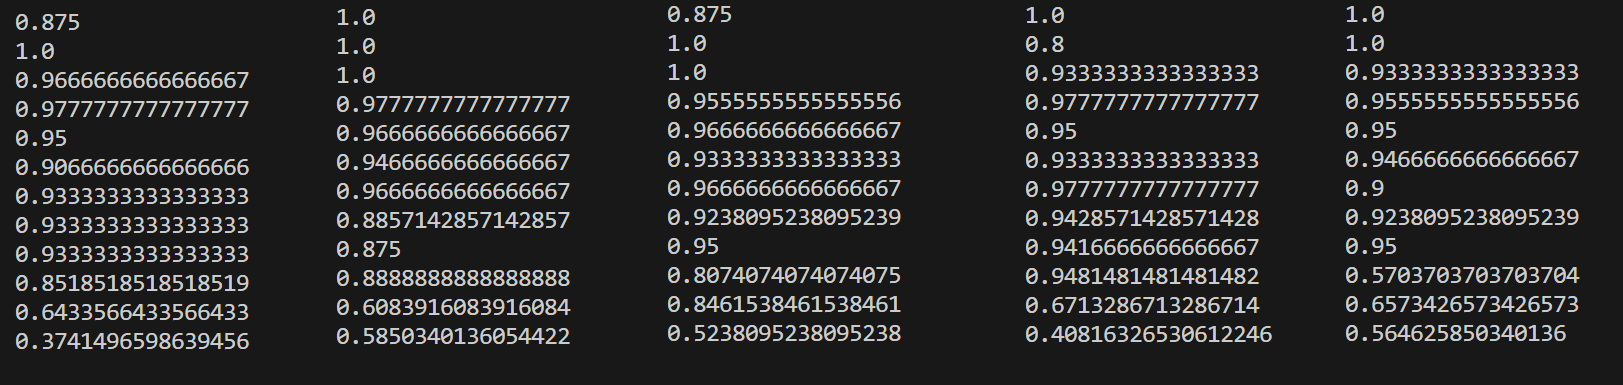



## Zwiększanie test_size - wnioski

- Jeśli test_size jest bardzo duży to mamy gorszą klasyfikacje, mamy wtedy bardzo mały zbiór uczący (przypadki gdy test_size to 95/98%)
- Nie zawsze mniejszy test_size (większy zbiór uczący) daje lepszy wyniki
- Ważne jest znalezienie odpowiedniej równowagi między rozmiarem zbioru testowego i uczącego